In [1]:
# Define the linear temperature model as a Python function. Key syntax elements here are:
# - def (a reserved keyword indicating that what follows will be a function)
# - temperature_model (the NAME of our function, we will use this to CALL the function)
# - round brackets (as opposed to SQUARE brackets which are used for lists and arrays!)
# - z, m, T0 (inputs to the function, variables it will use in its calculations)
# - T0=0 (this means that the third input, T0, is NOT REQUIRED, and if it is left out, will be set to 0)
# - ''' text ''' (the doc-string, kind of like a manual on the function's use)
# - return (the statement that ENDS the function and SENDS a value out of it)

def temperature_model(z, m, T0=0):
    ''' This is a doc-string. It is NOT required, but convention to include.
    
        It is essentially one large comment that carries information about the function. For example:
        ---
        Return temperature that is linear with depth.
        
        Inputs:
        -------
        z  : float
            depth
        m  : float
            geothermal gradient (linear coefficient)
        T0 : float
            surface temperature (constan coefficient, default = 0)
            
        Returns:
        --------
        T : float
            temperature
            
        Notes:
        ------
        Here I might include some more information about the model.
        
        Examples:
        ---------
        >>> temperature_model(z=10.0, m=2.0, T0=25.0)
        45.
    '''
    T = m*z + T0
    return T

In [2]:
# a simple example, and the output should make sense (10 times 2 equals 20, plus 25 equals 45)
T = temperature_model(z=10.0, m=2.0, T0=25.0)
print(T)

45.0


In [3]:
T10 = temperature_model(10, 2, 25)          # note, I don't need to do *input = *, providing I get the order of the arguments correct
T20 = temperature_model(20, 2, 25)
T30 = temperature_model(30, 2, 25)
T40 = temperature_model(40, 2, 25)
T50 = temperature_model(50, 2, 25)

print(T10, T20, T30, T40, T50)

45 65 85 105 125


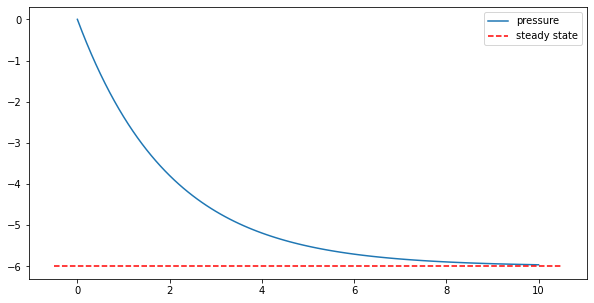

In [4]:

import numpy as np
from matplotlib import pyplot as plt

# a function can be defined and returned all on one line (but this restricts the calculation to one line)
def P(t,a,b,q0): return b*q0/a*(1-np.exp(a*t))     # define the analytic solution as a function
t = np.linspace(0,10,101)                          # an array of times to plot the solution
a,b,q0 = [-.5,1,3.]                                  # some parameters
f,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(t, P(t,a,b,q0), label='pressure')          # plot the solution

# plot the steady state as a horizontal line
xlim = ax.get_xlim()                               # get the plotting limits
p_ss = b*q0/a
ax.plot(xlim, [p_ss, p_ss], 'r--', label = 'steady state')
ax.legend()

In [6]:
def lpm_oscillating(p, t, a, b, c): 
    return a*p - b*(1+np.sin(t)) + c*np.cos(t)

Text(0.5, 0, 'time')

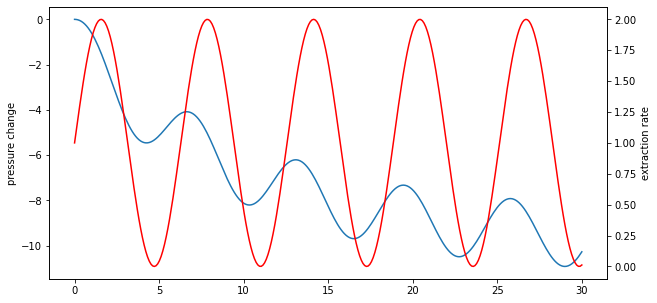

In [7]:
from scipy.integrate import odeint           # get the ODE tools
t = np.linspace(0,30,300)                    # array of times to get solution 
p0 = 0.                                      # we need to know where the solution starts, the initial value
                                             # as before, I am assuming that P = 0 when t = 0
pars = (-0.1, 1., 1.0)                       # we need to set the parameter values, in this case I am choosing
                                             # a = -0.1, b = 1 and c = 1
    
# now just pass all this info into the ODE solver
p = odeint(lpm_oscillating, y0=p0, t=t, args=pars)

# plot the solution
f,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(t, p)
ax.set_ylabel('pressure change')

# Here's a nifty thing, we can create a duplicate axis over the top of an existing one and MAKE 
# them share the x axis. This way, I can plot one quantity on the left axis, and another on the right,
# while still allowing that they have different scales!
ax2 = ax.twinx()
ax2.plot(t, 1+np.sin(t),'r-')
ax2.set_ylabel('extraction rate')
ax2.set_xlabel('time')

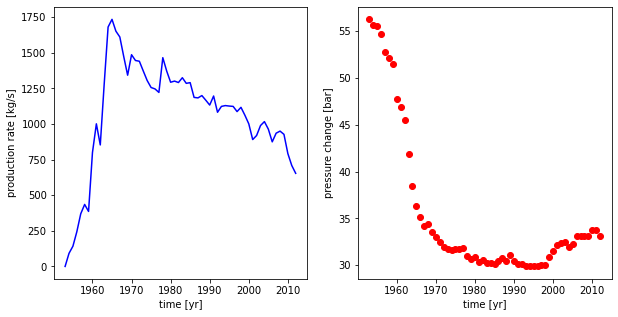

In [8]:

tq, q = np.genfromtxt('wk_production_history.csv', delimiter=',', unpack=True)
tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)

# plot the data (so should this!)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(tq,q,'b-')
ax1.set_xlabel('time [yr]')
ax1.set_ylabel('production rate [kg/s]')

ax2.plot(tp,p,'ro')
ax2.set_xlabel('time [yr]')
ax2.set_ylabel('pressure change [bar]');

In [10]:
# the details of this model aren't super important 
# ...unless you're feeling adventurous, then have at it
def lpm_wk(t,a,b,c,q_future = None):
    ''' Lumped parameter model for calibration.
    
    Inputs:
    -------
    t : array-like
        time (independent variable)
    a : float
        parameter coefficient of first term of ODE
    b : float
        parameter coefficient of second term of ODE
    c : float 
        parameter coefficient of third term of ODE
    q_future: float
        constant flow rate for post calibration period (for model prediction)
        
    Notes:
    ------
    To be used as an input to curve_fit (automatic Python calibration) this function MUST be defined
    with the independent variable as the first input, and parameters as subsequent inputs.
    '''
    # rescale the parameters
    a = a*1.e-8               # [s-1]
    b = b*1.e-5               # [m-1.s-2]
    c = c*1.e3                # [m-1.s-1]
    
    dt = 365*24*3600.         # time step [s]
    p0 = 56.26e5              # initial reservoir pressure [Pa]

    # load production history
    tq,q = np.genfromtxt('wk_production_history.csv', delimiter = ',', unpack=True)
    # append future flow rate if appropriate
    if q_future is not None:
        tq = np.concatenate([tq, np.arange(tq[-1]+1, tq[-1]+51, 1)])
        q = np.concatenate([q, q_future*np.ones(50)])
    
    # solve the ODE (we're not using scipy ODE method now)
    p = [p0]                  # initial value [Pa]
    for i in range(len(q)-2): # iteration using improved Euler method
        y0 = p0-p[-1]
        f0 = -a*(y0)+b*q[i]+c*(q[i+1]-q[i])/dt
        y1 = y0 + dt*f0
        f1 = -a*(y1)+b*q[i+1]+c*(q[i+2]-q[i+1])/dt
        y2 = y0 + (dt/2)*(f0+f1)
        p.append(p0-y2)

    # last step, we'll interpolate (piecewise linear) the solution onto the array of input times
    pi = np.interp(t, tq[:-1], p) 
    return pi*1.e-5    # reservoir pressure [bars]

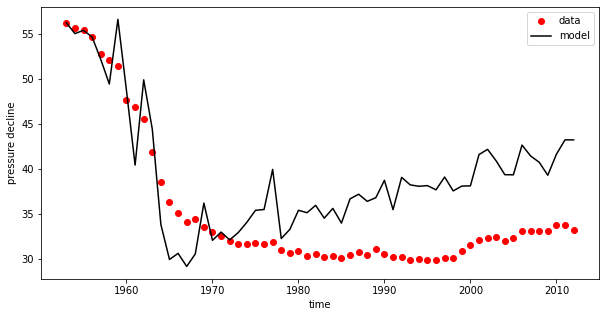

In [12]:
# we'll wrap the plot commands up in a function, this will be helpful for later
def plot_wk_model(a,b,c,q_future=None): 
    f,ax = plt.subplots(1,1,figsize=(10,5))
    tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)
    ax.plot(tp, p, 'ro', label='data')                           # plot the data
    if q_future is None:
        # plot model up to end of the calibration period
        ax.plot(tp, lpm_wk(tp,a,b,c), 'k-', label='model')  
    else: 
        # plot calibration and future period
        tp = np.linspace(tp[0], tp[-1]+50., 101)
        ax.plot(tp, lpm_wk(tp,a,b,c,q_future), 'k-', label='model')  
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('pressure decline')
    plt.show()

# plot the model for a = 5, b = 8, c = -3
plot_wk_model(5, 8, -3)

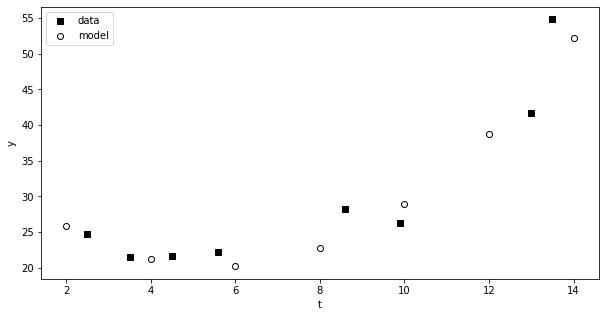

In [13]:
# define some data
ti = np.array([2.5, 3.5, 4.5, 5.6, 8.6, 9.9, 13.0, 13.5])
yi = np.array([24.7, 21.5, 21.6, 22.2, 28.2, 26.3, 41.7, 54.8])

# define a model
def model(t,a,b,c):
    ''' Implement a simple quadratic model.
    
        y = a*t^2 + b*t + c
    '''
    
    return a*t**2 + b*t + c

# define some output times and evaluate the model
tj = np.linspace(2., 14., 7)
yj = model(tj, 0.45, -5, 34)

# plotting
f,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ti,yi,'ks',label = 'data')
ax.plot(tj,yj,'wo', mec = 'k', label = 'model')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend();

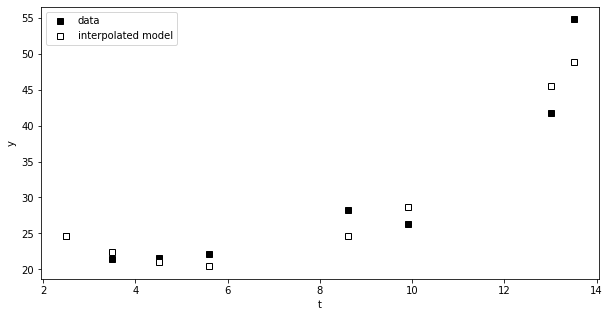

In [14]:
# interpolation
# - first input, where we want to interpolate the model TO (the times of the data)
# - second input, the TIMES of the model
# - third input, the VALUES of the model
y_int = np.interp(ti, tj, yj)

# plotting
f,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ti,yi,'ks',label = 'data')
ax.plot(ti, y_int,'ws', mec = 'k', label = 'interpolated model')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend();

In [15]:
from ipywidgets import interact, fixed
interact(plot_wk_model, a = (0., 6, 0.1), b = (0, 6, 0.1), c = (-5, 5, 0.1), q_future = fixed(None));

interactive(children=(FloatSlider(value=3.0, description='a', max=6.0), FloatSlider(value=3.0, description='b'…

In [17]:
from scipy.optimize import curve_fit                     # the function we'll be using for automatic calibration

# the inputs to curve_fit are, in order
# - a function, representing the model (see above definition of lpm_wk)
# - an array of independent variables, corresponding to the data/measurements
# - an array of dependent variables, the data/measurements
# - an initial guess of the parameters (in our case, initial a, b and c)
# there are two outputs: the best-fitting parameter values and their covariances (we'll ignore the second part)

# let's see how it works!
    # load in the data again
tp, p = np.genfromtxt('wk_pressure_history.csv', delimiter=',', unpack=True)
    # define an initial guess for the parameters
par_i = [5, 8, -3]
par, pcov = curve_fit(lpm_wk, tp, p, par_i)
print(par)

[0.21226718 0.49149909 0.78680413]
[0.21226718 0.49149909 0.78680413]


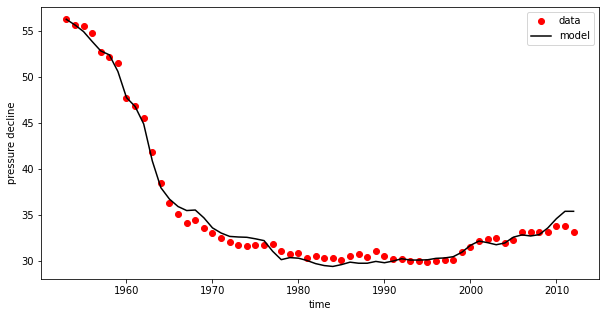

In [19]:
a_fit, b_fit, c_fit = par                 # 'unpack' the list of best-fit parameters to individual variables
plot_wk_model(a_fit, b_fit, c_fit)

In [20]:
# convert fitted parameters to SI values (see lpm_wk definition for more details)
a_SI = a_fit*1.e-8      # [/s]
b_SI = b_fit*1.e-5      # [/m /s^2]
c_SI = c_fit*1.e3       # [/m /s]

# other reservoir parameters (SI values)
g = 9.81                # [m/s^2]
A = 15.e6               # [m^2]
S0 = 0.3                # []

# calculate porosity
phi = (g/(A*(1-S0)))/(b_SI**2/(b_SI-a_SI*c_SI))
print(phi)

0.12549625480314633


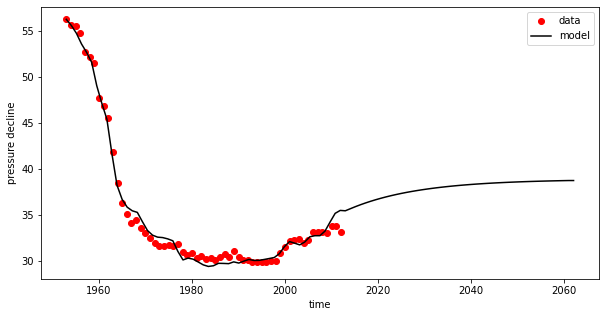

In [21]:
# case 1: production continues
plot_wk_model(a_fit, b_fit, c_fit, q_future = 750.)

# case 2: production stops
#plot_wk_model(a_fit, b_fit, c_fit, q_future = 0.)
